In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
import statsmodels.stats.api as stats
import statsmodels.formula.api as smf

from sksurv.nonparametric import kaplan_meier_estimator

from warnings import simplefilter, warn
simplefilter('ignore', category=UserWarning)

import os
from dotenv import load_dotenv; load_dotenv('../.env')
from mysql.connector import connect

# Datos de Paciente


In [2]:
pat1 = pd.read_csv('../data/raw/patients_batch1.csv', parse_dates = ['birth_date', 'diagnosis_date', 'death_date'])
pat2 = pd.read_csv('../data/raw/patients_batch2.csv', parse_dates = ['birth_date', 'diagnosis_date', 'death_date'])
print("Dimensión de Conjunto 1: ", pat1.shape[0])
print("Dimensión de Conjunto 2: ", pat2.shape[0])
display(pat1.head())


Dimensión de Conjunto 1:  7500
Dimensión de Conjunto 2:  3000


,ehr,birth_date,diagnosis_date,death_date
0,10011773,1959-07-05,2015-04-02,NaT
1,10020495,1953-10-02,2017-12-04,NaT
2,10030299,1966-08-16,2019-06-27,NaT
3,10030824,1953-03-03,2018-09-07,NaT
4,10041592,1959-07-06,2018-11-19,NaT


In [3]:
def preprocess_patients(pat, check_filter: bool = False):
    """
    Preprocesado de los Pacientes. Añade columnas, elimina / imputa nulos.
    """

    YEAR  = 365.24
    MONTH =  30.437

    pat = pat.copy()
    now = pd.Timestamp.now()

    pat['is_alive']   = pat['death_date'].isna()
    pat['age']   = ((now - pat['birth_date']).dt.days / YEAR).astype(int)
    if check_filter: assert all(pat['age'] > 0), "Hay personas con nacidas en el fúturo. Fecha de nacimiento superior a fecha actual"
    else:
        mask1 = pat['age'] < 0
        if any(mask1): 
            n_dates = sum(mask1)
            warn(f"Hay {n_dates: 5d} personas con nacidas en el fúturo. Fecha de nacimiento superior a fecha actual. Se han eliminado. Limpiando linea temporal")
            
        pat = pat[~mask1]
    # Comprobations
    pat['diag_dur']   = ((pat['death_date'] - pat['diagnosis_date']).dt.days / MONTH)
    pat['diag_dur']   = pat['diag_dur'].fillna(((now - pat['diagnosis_date']).dt.days / MONTH))
    pat['diag_dur']   = pat['diag_dur'].astype(int)

    if check_filter: assert all(pat['diag_dur'] > 0), "Hay diagnosticos realizados antes de la fecha de muerte"
    else:
        mask1 = pat['diag_dur'] < 0
        if any(mask1): 
            n_dates = sum(mask1)
            warn(f"Hay {n_dates: 5d} diagnosticos realizados antes de la fecha de muerte. Se han eliminado")
            
        pat = pat[~mask1]

    pat['diag_age']   = pat['age'] - pat['diag_dur']

    # Discretizar la Edad
    age_bins = [0, 12, 18, 35, 50, 65, 85, 100]
    age_labels = ['Child', 'Teenager', 'Adult', 'Adult +', 'Senior', 'Senior +', 'Senior ++']

    pat['age_bin'] = pd.cut(pat['age'], bins = age_bins, labels = age_labels, right = False)
    
    # Limpieza de Variables
    pat = pat.drop(columns = ['birth_date', 'diagnosis_date', 'death_date'])
    return pat
# Extra variable
dpat1 = preprocess_patients(pat1, check_filter=False)
dpat2 = preprocess_patients(pat2, check_filter=False)

dpat = pd.concat([dpat1, dpat2], axis = 0)

dpat2.head()

,ehr,is_alive,age,diag_dur,diag_age,age_bin
0,72992494,True,81,64,17,Senior +
1,73002338,True,74,64,10,Senior +
2,73008149,True,54,60,-6,Senior
3,73012939,False,50,44,6,Senior
4,73019870,True,68,67,1,Senior +


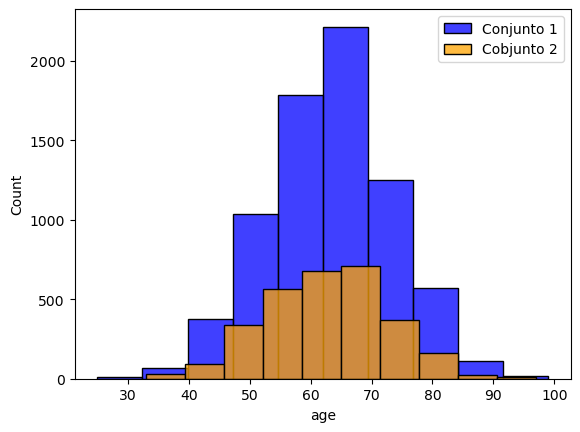

In [4]:
sns.histplot(data = dpat1, x = "age", bins = 10, color='blue'  , label = "Conjunto 1")
sns.histplot(data = dpat2, x = "age", bins = 10, color='orange', label = "Cobjunto 2")
plt.legend()
plt.show()


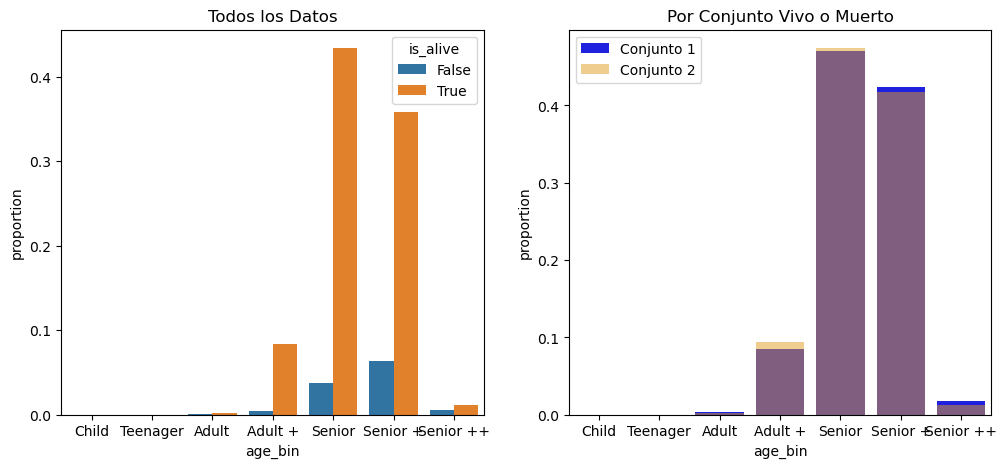

In [15]:
_, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].set_title("Todos los Datos")
sns.countplot(data = dpat,  x = 'age_bin', hue = 'is_alive', stat = 'proportion', ax = ax[0])
sns.countplot(data = dpat1, x = 'age_bin', stat = 'proportion', ax = ax[1], color = "blue"  , label = "Conjunto 1")
sns.countplot(data = dpat2, x = 'age_bin', stat = 'proportion', ax = ax[1], color = "orange", alpha = 0.5, label = "Conjunto 2")
ax[1].legend()
ax[1].set_title("Por Conjunto Vivo o Muerto")
plt.show()

In [26]:
ct = pd.crosstab(dpat['is_alive'], dpat['age_bin'])
t, pvalue, freedom, expected = st.chi2_contingency(ct, correction = False)

print(f"T: {t: 7.4f}\t P-Value: {pvalue: .3g}")
print("H0: P(T| Alive) y P(T| Dead) son independientes.")
print(f"Expected Observations")
pd.DataFrame(expected, index = ct.index, columns = ct.columns).round(1)

T:  216.6426	 P-Value:  9.89e-46
H0: P(T| Alive) y P(T| Dead) son independientes.
Expected Observations


age_bin,Adult,Adult +,Senior,Senior +,Senior ++
is_alive,,,,,
False,3.0,101.7,546.9,489.0,18.4
True,24.0,813.3,4375.1,3912.0,147.6


499


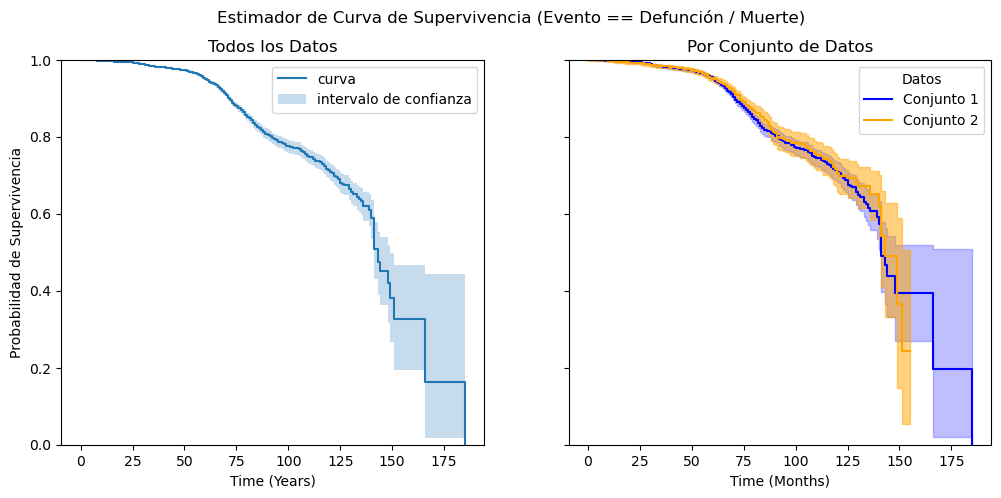

In [6]:
_, ax = plt.subplots(1, 2, figsize = (12, 5), sharey = True)
print(dpat['ehr'].duplicated().sum())

x, y, conf = kaplan_meier_estimator(np.logical_not(dpat['is_alive'].values), time_exit = dpat['diag_dur'], conf_type = 'log-log')
ax[0].step(x, y, where = "post", label = "curva")
ax[0].fill_between(x, conf[0], conf[1], alpha = 0.25, step = "post", label = "intervalo de confianza")
ax[0].set_ylim(0, 1)
ax[0].set_xlabel("Time (Years)")
ax[0].set_ylabel("Probabilidad de Supervivencia")
ax[0].set_title("Todos los Datos")
ax[0].legend()

x, y, conf = kaplan_meier_estimator(np.logical_not(dpat1['is_alive'].values), time_exit = dpat1['diag_dur'], conf_type = 'log-log')
ax[1].step(x, y, where = "post", label = "Conjunto 1", color = 'blue')
ax[1].fill_between(x, conf[0], conf[1], alpha = 0.25, step = "post", color = "blue")

x, y, conf = kaplan_meier_estimator(np.logical_not(dpat2['is_alive'].values), time_exit = dpat2['diag_dur'], conf_type = 'log-log')
ax[1].step(x, y, where = "post", label = "Conjunto 2", color = "orange")
ax[1].fill_between(x, conf[0], conf[1], alpha = 0.5, step = "post" ,color = 'orange')

ax[1].set_ylim(0, 1)
ax[1].set_xlabel("Time (Months)")

ax[1].set_title("Por Conjunto de Datos")
ax[1].legend(title = "Datos")

plt.suptitle("Estimador de Curva de Supervivencia (Evento == Defunción / Muerte)")
plt.show()

# Datos Ginecológicos

In [7]:
gino = pd.read_excel('../data/raw/gynecological.xlsx', index_col = 0)
print("Dimensión Datos Ginecológicos:", gino.shape[0])
display(gino.head(n = 10))

Dimensión Datos Ginecológicos: 7686


,ehr,pregnancy,birth,caesarean,abort,menarche_age,menopause_age
0,10011773,-8.0,0.0,NaN,0.0,NaN,71.0
1,10030299,3.0,NaN,0.0,0.0,NaN,NaN
2,10030824,0.0,0.0,0.0,NaN,NaN,44.0
3,10053435,2.0,NaN,0.0,1.0,21.0,74.0
4,10111454,0.0,-6.0,NaN,0.0,16.0,55.0
5,10115313,2.0,0.0,0.0,2.0,18.0,44.0
6,10119160,1.0,1.0,0.0,0.0,15.0,48.0
7,10128601,3.0,NaN,0.0,0.0,14.0,53.0
8,10131227,7.0,7.0,NaN,NaN,12.0,NaN
9,10136878,NaN,5.0,10.0,0.0,10.0,NaN


In [8]:
def impute_births(row):
    
    cols =  ['pregnancy', 'birth', 'caesarean', 'abort']

    row_data = row.values.tolist()
    nulls = row.isna().tolist()
    nnull = sum(nulls)

    if row[0] == 0:
        row[1:] = [0, 0, 0] # No hay embarazos, por tanto no nada en el resto
        return row

    # inconsistencia
    if row[0] < np.nansum(row[1:]): # Embarazos < Cesareas + Nacimientos + Aborto
        return pd.Series([np.nan, np.nan, np.nan, np.nan], index = row.index)

    if nnull == 1:
        if nulls[0]: # Falta solamente el número de embarazos
            row[0] = sum(row_data[1:3])
        else: # Falta imputar el número de un tipo de resultado de un embarazo
            missing = np.where(nulls)[0][0]
            row[missing] = row_data[0] - np.nansum(row.values[1:])

    elif nnull == 2 and not nulls[0]:
        not_missing = np.where(np.logical_not(nulls[1:]))[0][0] + 1
        if row[not_missing] == row[0]: 
            row[1:] = [0, 0, 0]
            row[not_missing] = row[0]


    return row

for col in ['pregnancy', 'birth', 'caesarean', 'abort']: gino.loc[gino[col] < 0, col] = np.nan
det = gino[['pregnancy', 'birth', 'caesarean', 'abort']].apply(impute_births, axis = 1)

In [9]:
gino['pregnancy'] - np.nansum(gino.iloc[:, 1:4].values, axis = 1)

0       NaN
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7681   -2.0
7682   -2.0
7683   -3.0
7684   -3.0
7685    0.0
Name: pregnancy, Length: 7686, dtype: float64

In [10]:
x = pd.Series(np.arange(0, 4, dtype = np.float64), index = list("abcd"))
x[1] = np.nan
np.sum(x)

5.0

In [11]:
def read_tumor_data():
    conn = connect(user = os.environ.get('PCD_DB_USR'), 
                   password = os.environ.get('PCD_DB_PWD'), 
                   host = '127.0.0.1', port = 3306, 
                   database = 'tumordb'
                    )
    data = pd.read_sql("SELECT * FROM tumor;", conn)
    conn.close()

    return data

tumor = read_tumor_data()
print("Tamaño: ", tumor.shape)
tumor.head()


DatabaseError: 2003 (HY000): Can't connect to MySQL server on '127.0.0.1:3306' (10061)

In [ ]:
chemis = pd.read_json('../data/raw/histochemistry.json')
print("Tamaño: ", chemis.shape)

display(chemis.head())

chemis.info()


Tamaño:  (10000, 5)


,ehr,er,her2,ki67,pr
0,10011773,0.0,0.0,19.0,NaN
1,10020495,1.0,0.0,9.0,0.0
2,10030299,1.0,NaN,18.0,1.0
3,10030824,1.0,0.0,NaN,1.0
4,10041592,0.0,0.0,65.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ehr     10000 non-null  int64  
 1   er      9042 non-null   float64
 2   her2    9006 non-null   float64
 3   ki67    9032 non-null   float64
 4   pr      9018 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 390.8 KB
